# **SCTP Assoc AI/ML Developer: Log Data Classification**

# Notebook Init

In [1]:
import os
print('KAGGLE_GCP_ZONE' in list(os.environ.keys()))
print('COLAB_RELEASE_TAG' in list(os.environ.keys()))

RunningInKaggle = 'KAGGLE_GCP_ZONE' in list(os.environ.keys())
print(RunningInKaggle)
RunningInCOLAB = 'google.colab' in str(get_ipython()) if hasattr(__builtins__,'__IPYTHON__') else False
print(RunningInCOLAB)

False
False
False
False


In [2]:
import tensorflow as tf

def gpu_check():
    # check
    !nvidia-smi
    print(f"tensorflow version: {tf.__version__}")
    gpus = tf.config.list_physical_devices('GPU')
    cpus = tf.config.list_physical_devices('CPU')
    print(gpus)
    print(cpus)

def gpu_set(p_enable: bool=False):
    gpu_check()
    gpus = tf.config.list_physical_devices('GPU')
    cpus = tf.config.list_physical_devices('CPU')
    try:
        if p_enable:
            tf.debugging.set_log_device_placement(True)
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
                # tf.config.set_visible_devices(gpus[0], 'GPU')
                tf.config.set_visible_devices(gpu, 'GPU')
            logical_gpus = tf.config.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        else:
            tf.config.set_visible_devices(cpus[0], 'CPU')
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

# mount google drive in colab
def mount_gg_drive():
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

def git_clone(p_url: str=None):
    !git clone https://github.com/NMustikha/SCTP-Capstone-4-Fraud-Detection

def find_files(p_dir: str = '/kaggle'):
    for dirname, _, filenames in os.walk(p_dir):
        for filename in filenames:
            print(os.path.join(dirname, filename))


2024-09-02 19:19:47.793316: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-02 19:19:48.014643: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-02 19:19:48.068788: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-02 19:19:48.465161: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-02 19:19:50.403409: W tensorflow/compiler/tf2

In [4]:
from pathlib import Path
import tensorflow as tf

gpu_check()
gpu_set(True)
# gpu_set(False)

# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#     try:
#         # Currently, memory growth needs to be the same across GPUs
#         for gpu in gpus:
#             tf.config.set_visible_devices(gpus[0], 'GPU')
#             tf.config.experimental.set_memory_growth(gpu, True)

#             logical_gpus = tf.config.list_logical_devices('GPU')
#             print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#     except RuntimeError as e:
#         # Memory growth must be set before GPUs have been initialized
#         print(e)

# if RunningInCOLAB:
#     mount_gg_drive()
#     # git_clone()
# elif RunningInKaggle:
#     BASE_DIR = '/kaggle'
#     CWD = str(Path.cwd())
#     INPUT_DIR = BASE_DIR+'/input'
    
#     print(f"BASE_DIR = {BASE_DIR}")
#     print(f"CWD = {CWD}")
#     print(f"INPUT_DIR = {INPUT_DIR}")
    
#     print(f"\nFile listing in {BASE_DIR}")
#     find_files(p_dir = BASE_DIR)
# else:
#     pass

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Mon Sep  2 09:05:55 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8             10W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
# install python packages
# %pip install -r /content/drive/MyDrive/sctp-capstone-ml-log-data/requirements.txt
# %pip install -r /kaggle/input/sctp-requirements/requirements.txt
%pip install -r ./requirements.txt

  Using cached pydantic-2.8.2-py3-none-any.whl.metadata (125 kB)
  Using cached semantic_version-2.10.0-py2.py3-none-any.whl.metadata (9.7 kB)
  Using cached annotated_types-0.7.0-py3-none-any.whl.metadata (15 kB)
  Using cached pydantic_core-2.20.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 91.7 MB/s eta 0:00:00
Using cached pydantic-2.8.2-py3-none-any.whl (423 kB)
Using cached pydantic_core-2.20.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.1 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 81.0 MB/s eta 0:00:00
Using cached semantic_version-2.10.0-py2.py3-none-any.whl (15 kB)
Using cached annotated_types-0.7.0-py3-none-any.whl (13 kB)
Note: you may need to restart the kernel to use updated packages.


In [5]:
# import libraries
import pandas
pandas.options.display.max_columns = None
pandas.set_option('display.max_columns', None)
pandas.option_context('mode.use_inf_as_na', True)

import os
import shutil
from pathlib import Path
import pandas as pd
import numpy as np
from pprint import pprint as pp
import csv
import contractions
import string
import re
from unidecode import unidecode
import gradio as gr
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import dateutil
from chardet import detect
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Dataset

Dataset on log files are hosted at [Public Security Log Sharing Site](https://log-sharing.dreamhosters.com/), supported by [Dr. Anton A. Chuvakin](https://www.chuvakin.org/)

Bundle 1 log files is selected and accessible at [http://log-sharing.dreamhosters.com/hnet-hon-var-log-02282006.tgz](http://log-sharing.dreamhosters.com/hnet-hon-var-log-02282006.tgz)


The target log files for analysis are found in:
- `/var/log/httpd/access_log*`
- `/var/log/messages*`

These log files are:
- download the log file bundle
- untar the bundle
- respective log files are concatenated


In [6]:
!curl -L http://log-sharing.dreamhosters.com/hnet-hon-var-log-02282006.tgz -o hnet-hon-var-log-02282006.tgz
!tar -C ./ -xvf hnet-hon-var-log-02282006.tgz

!ls ./var/log/httpd/ | grep access_log | xargs -I {} cat "./var/log/httpd/{}" >> ./access_log
!ls ./var/log/ | grep messages | xargs -I {} cat "./var/log/{}" >> ./messages

# !cp ./access_log ./messages /content/drive/MyDrive/sctp-capstone-ml-log-data/dataset/

# cleanup
# !rm -rf ./hnet-hon-var-log-02282006.tgz ./var

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   274  100   274    0     0    391      0 --:--:-- --:--:-- --:--:--   390
100  100M  100  100M    0     0  10.7M      0  0:00:09  0:00:09 --:--:-- 17.0M     0  10.6M      0  0:00:09  0:00:09 --:--:-- 16.2M
var/log/
var/log/boot.log.30
var/log/tmplog
var/log/cron.2
var/log/cron.25
var/log/mysqld.log.23
var/log/mysqld.log.19
var/log/secure.20
var/log/maillog.8
var/log/maillog.15
var/log/messages.19
var/log/boot.log.9
var/log/boot.log.29
var/log/maillog.14
var/log/maillog.12
var/log/secure.16
var/log/snmpd.log.6
var/log/secure.13
var/log/rpmpkgs.25
var/log/spooler.6
var/log/messages.31
var/log/rpmpkgs.19
var/log/mysqld.log.15
var/log/cron.17
var/log/mysqld.log.2
var/log/rpmpkgs.21
var/log/cron.6
var/log/mysqld.log
var/log/secure.28
var/log/mysqld.log.29
var/log/maillog.5
var/log/messages.21
var/log/messages.23
var/log/messages.2

In [8]:
find_files()

/kaggle/lib/kaggle/gcp.py
/kaggle/input/sample-log-data/log_data_dataset.csv
/kaggle/input/sctp-requirements/requirements.txt
/kaggle/working/access_log
/kaggle/working/hnet-hon-var-log-02282006.tgz
/kaggle/working/messages
/kaggle/working/var/log/secure.14
/kaggle/working/var/log/boot.log.25
/kaggle/working/var/log/spooler.8
/kaggle/working/var/log/boot.log.13
/kaggle/working/var/log/maillog.16
/kaggle/working/var/log/rpmpkgs.21
/kaggle/working/var/log/secure.24
/kaggle/working/var/log/maillog.22
/kaggle/working/var/log/maillog.26
/kaggle/working/var/log/spooler.5
/kaggle/working/var/log/boot.log.20
/kaggle/working/var/log/rpmpkgs.14
/kaggle/working/var/log/dmesg
/kaggle/working/var/log/secure.23
/kaggle/working/var/log/messages.21
/kaggle/working/var/log/secure.11
/kaggle/working/var/log/lastlog
/kaggle/working/var/log/mysqld.log.24
/kaggle/working/var/log/tmplog
/kaggle/working/var/log/boot.log.19
/kaggle/working/var/log/messages.22
/kaggle/working/var/log/spooler.30
/kaggle/working

# Load, Clean and Convert to CSV File

Main steps:
1. Remove non-ascii characters from log files
2. Convert log file to csv structure


In [9]:
if RunningInCOLAB:
    # DATA_DIR = "../data" # local vs code setup
    DATA_DIR = "/content" # google colab
    HTTP_ACCESS_LOG_FILE = DATA_DIR+"/"+"access_log"
    MESSAGES_FILE = DATA_DIR+"/"+"messages"

    HTTP_ACCESS_LOG_CSV = DATA_DIR+"/"+"access_log_final.csv"
    MESSAGES_CSV = DATA_DIR+"/"+"messages_final.csv"

    # filename for persisting the vectorizer and model
    TFIDF_FILE = '/content/drive/MyDrive/sctp-capstone-ml-log-data/model/'+'tfidf_vectorizer.sav'
    MODEL_FILE = '/content/drive/MyDrive/sctp-capstone-ml-log-data/model/'+'log_classifier_model.sav'

    mount_gg_drive()

elif RunningInKaggle:
    CWD = str(Path.cwd())
    DATA_DIR = CWD # kaggle
    HTTP_ACCESS_LOG_FILE = DATA_DIR+"/"+"access_log"
    MESSAGES_FILE = DATA_DIR+"/"+"messages"

    HTTP_ACCESS_LOG_CSV = DATA_DIR+"/"+"access_log_final.csv"
    MESSAGES_CSV = DATA_DIR+"/"+"messages_final.csv"

    # filename for persisting the vectorizer and model
    TFIDF_FILE = CWD+'/'+'tfidf_vectorizer.sav'
    MODEL_FILE = CWD+'/'+'log_classifier_model.sav'

    BASE_DIR = '/kaggle'
    INPUT_DIR = BASE_DIR+'/input'
    
    print(f"BASE_DIR = {BASE_DIR}")
    print(f"CWD = {CWD}")
    print(f"INPUT_DIR = {INPUT_DIR}")
    
    print(f"\nFile listing in {BASE_DIR}")
    find_files(p_dir = BASE_DIR)
else:
    # running locally (PC/laptop)
    CWD = str(Path.cwd())
    # str(Path.cwd())
    DATA_DIR = CWD 
    HTTP_ACCESS_LOG_FILE = DATA_DIR+"/"+"access_log"
    MESSAGES_FILE = DATA_DIR+"/"+"messages"

    HTTP_ACCESS_LOG_CSV = DATA_DIR+"/"+"access_log_final.csv"
    MESSAGES_CSV = DATA_DIR+"/"+"messages_final.csv"

    # filename for persisting the vectorizer and model
    TFIDF_FILE = CWD+'/'+'tfidf_vectorizer.sav'
    MODEL_FILE = CWD+'/'+'log_classifier_model.sav'


# if RunningInCOLAB:
#     mount_gg_drive()
#     # git_clone()
# elif RunningInKaggle:
#     BASE_DIR = '/kaggle'
#     CWD = str(Path.cwd())
#     INPUT_DIR = BASE_DIR+'/input'
    
#     print(f"BASE_DIR = {BASE_DIR}")
#     print(f"CWD = {CWD}")
#     print(f"INPUT_DIR = {INPUT_DIR}")
    
#     print(f"\nFile listing in {BASE_DIR}")
#     find_files(p_dir = BASE_DIR)
# else:
#     pass

print(MODEL_FILE)

/home/franklin/data/dat/sctp-caps-log-classifier/log_classifier_model.sav


In [10]:
from chardet import detect
def has_non_ascii(p_file: str = None):
    cnt = 0
    encoding = lambda x: detect(x)['encoding']
    # with open(tgt_file+".txt", 'a', encoding='utf-a') as fout:
    with open(tgt_file, 'rb') as f:
        for i in f.readlines():
            cnt += 1
            if encoding(i) != 'ascii':
                # print(f"line {cnt} ... contains non-ascii characters.")
                print(f"File {p_file} has non-ascii characters ... line [{cnt}] onwards.")

            # exit when first detected non-ascii line
            if cnt>0: return True
            else: return False


def scrub_non_ascii(p_file: str = None):
    cnt = 0
    encoding = lambda x: detect(x)['encoding']

    tgt_file = p_file
    cnt = 0
    line_nums = []
    # detect lines with non-ascii characters
    # https://www.w3schools.com/charsets/ref_html_8859.asp
    with open(tgt_file, 'rb') as fin:
        for i in fin.readlines():
            cnt += 1
            if encoding(i) != 'ascii':
                # print(f"line {cnt} ... contains {encoding(i)} characters ... ignored")
                line_nums.append(cnt)
            # else:
            #     print(f"line {cnt} ... contains {encoding(i)} characters")


    print(f"Lines with non-ascii characters:\n{line_nums}")
    cnt = 0
    with open(tgt_file, 'r', encoding='utf-8', errors='ignore') as fin:
        with open(tgt_file+".txt", 'w', encoding='utf-8') as fout:
            for i in fin.readlines():
                cnt += 1
                if cnt in line_nums:
                    print(f"line {cnt} ... skipped due to presence of non-ascii character.")
                else:
                    fout.write(i)
    print(f"New file written to [{tgt_file}.txt]")
    return f"{tgt_file}.txt"

def clean_str(p_str: str=None):

    str_lower = lambda x: str(x).lower() # lower casing
    str_exp_contraction = lambda x: " ".join([contractions.fix(expanded_word) for expanded_word in x.split()]) # expand contractions
    str_rm_punct = lambda x: re.sub('[%s]' % re.escape(string.punctuation.replace('/', '').replace('@','')), ' ' , x) # remove punctuations except '/' and '@'
    str_rm_spaces = lambda x: re.sub(' +', ' ', x) # remove double spaces
    str_rpl_diacritics = lambda x: unidecode(x, errors="preserve") # replace Diacritics with nearest characters.

    p_str = str_lower(p_str)
    p_str = str_exp_contraction(p_str)
    p_str = str_rm_punct(p_str)
    p_str = str_rm_spaces(p_str)
    p_str = str_rpl_diacritics(p_str)
    return p_str

def clean_logs(p_entry: pandas.Series=None):
    p_entry = pandas.Series(p_entry).apply(clean_str)
    return p_entry
    # print(f"p_entry ... {type(p_entry)}")
    # print(f"{p_entry}")
    # return p_entry
    # result = []

    # for i in p_entry:
    #     clean_str(str(i))
    #     result.append(clean_str(str(i)))
    # return pandas.Series(result)


import pickle

# def save_model(p_obj=None, p_filename: str='/content/drive/MyDrive/sctp-capstone-ml-log-data/model/'+'log_classifier_model.sav'):
def save_obj(p_obj=None, p_filename: str='/content/drive/MyDrive/sctp-capstone-ml-log-data/model/'+'log_classifier_model.sav'):
    # save the model to disk
    filename = '/content/drive/MyDrive/sctp-capstone-ml-log-data/model/'+'log_classifier_model.sav'
    # pickle.dump(best_model, open(filename, 'wb'))
    pickle.dump(p_obj, open(p_filename, 'wb'))

# def load_model(p_filename: str = '/content/drive/MyDrive/sctp-capstone-ml-log-data/model/'+'log_classifier_model.sav'):
def load_obj(p_filename: str = '/content/drive/MyDrive/sctp-capstone-ml-log-data/model/'+'log_classifier_model.sav'):
    # load the model from disk
    # filename = '/content/drive/MyDrive/sctp-capstone-ml-log-data/model/'+'log_classifier_model.sav'
    return pickle.load(open(p_filename, 'rb'))


### convert httpd `access_log` to csv format

In [11]:
tgt_file = HTTP_ACCESS_LOG_FILE

In [12]:
import csv

def httpd_access_log_to_csv(p_file: str = None) -> list:
    logs = list()
    cnt = 0
    tgt_file = p_file
    if has_non_ascii(tgt_file):
        tgt_file = scrub_non_ascii(tgt_file)

    with open(tgt_file, 'r') as f:
        for i in f.readlines():
            cnt += 1
            # print(cnt)
            j = (i
                .replace('- [', '- @@')
                .replace('] "', '@@ "')
            )
            k = [ m.strip() for m in j.split('@@')]
            k[0] = k[0].replace(' - -', '')
            k[1] = k[1].replace(' -0500', '')
            k[1] = k[1].replace(' -0400', '')
            # k[2] = (k[2]
            #         .replace('"', '][')
            #         )        # print(k)
            k[2] = k[2][1:-1]
            k.append('httpd_access_log')
            logs.append(k)
    return logs


logs = httpd_access_log_to_csv(tgt_file)
fields = ['ipaddress','datetime','content','log_type']
# pp(logs[:3])
with open(tgt_file+'.csv', 'w') as f:
    # using csv.writer method from CSV package
    write = csv.writer(f)
    write.writerow(fields)
    write.writerows(logs)

pp(logs[:2])


Lines with non-ascii characters:
[]
New file written to [/home/franklin/data/dat/sctp-caps-log-classifier/access_log.txt]
[['66.186.236.233',
  '22/Jan/2006:07:35:42',
  'GET / HTTP/1.1" 403 3931 "-" "Mozilla/4.0 (compatible; MSIE 5.5; Windows '
  '98)',
  'httpd_access_log'],
 ['65.103.133.250',
  '22/Jan/2006:07:56:32',
  'GET / HTTP/1.1" 403 3931 "-" "Mozilla/4.0 (compatible; MSIE 5.5; Windows '
  '98)',
  'httpd_access_log']]


In [13]:
tgt_file = HTTP_ACCESS_LOG_FILE+'.csv'

df = pd.read_csv(tgt_file)
display(df.head())
display(df['content'].head())
# print(f"[{df[:2]['datetime'].str.lower()}]")
# df['date'] = df['datetime'].str[:11]
# df['time'] = df['datetime'].str[12:]
df['datetime'] = df['datetime'].str.replace(":"," ", 1)
df['datetime'] = pd.to_datetime(df['datetime'],dayfirst=True)
df['day'] = df['datetime'].dt.day
df['month'] = df['datetime'].dt.month
df['year'] = df['datetime'].dt.year
# df['day_of_week'] = df['datetime'].dt.day_name()
df['hour'] = df['datetime'].dt.hour
df['minute'] = df['datetime'].dt.minute
df['second'] = df['datetime'].dt.second
df.drop('ipaddress', inplace=True, axis=1)

df.info()
display(df.head())

df['content'] = clean_logs(df['content'])
# display(df['content'].head())
display(df.head())

# df = df[df['content'].notnull()]
# display(df[df['content'].isnull()])

tgt_file = HTTP_ACCESS_LOG_FILE+'_final.csv'
df.to_csv(tgt_file,index=False)


,ipaddress,datetime,content,log_type
0,66.186.236.233,22/Jan/2006:07:35:42,"GET / HTTP/1.1"" 403 3931 ""-"" ""Mozilla/4.0 (com...",httpd_access_log
1,65.103.133.250,22/Jan/2006:07:56:32,"GET / HTTP/1.1"" 403 3931 ""-"" ""Mozilla/4.0 (com...",httpd_access_log
2,62.175.253.180,22/Jan/2006:08:28:17,GET /awstats/awstats.pl?configdir=|echo;echo%2...,httpd_access_log
3,62.175.253.180,22/Jan/2006:08:28:17,GET /awstats/awstats.pl?configdir=|echo;echo%2...,httpd_access_log
4,62.175.253.180,22/Jan/2006:08:28:17,GET /awstats/awstats.pl?configdir=|echo;echo%2...,httpd_access_log


0    GET / HTTP/1.1" 403 3931 "-" "Mozilla/4.0 (com...
1    GET / HTTP/1.1" 403 3931 "-" "Mozilla/4.0 (com...
2    GET /awstats/awstats.pl?configdir=|echo;echo%2...
3    GET /awstats/awstats.pl?configdir=|echo;echo%2...
4    GET /awstats/awstats.pl?configdir=|echo;echo%2...
Name: content, dtype: object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36424 entries, 0 to 36423
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  36424 non-null  datetime64[ns]
 1   content   36424 non-null  object        
 2   log_type  36424 non-null  object        
 3   day       36424 non-null  int32         
 4   month     36424 non-null  int32         
 5   year      36424 non-null  int32         
 6   hour      36424 non-null  int32         
 7   minute    36424 non-null  int32         
 8   second    36424 non-null  int32         
dtypes: datetime64[ns](1), int32(6), object(2)
memory usage: 1.7+ MB


,datetime,content,log_type,day,month,year,hour,minute,second
0,2006-01-22 07:35:42,"GET / HTTP/1.1"" 403 3931 ""-"" ""Mozilla/4.0 (com...",httpd_access_log,22,1,2006,7,35,42
1,2006-01-22 07:56:32,"GET / HTTP/1.1"" 403 3931 ""-"" ""Mozilla/4.0 (com...",httpd_access_log,22,1,2006,7,56,32
2,2006-01-22 08:28:17,GET /awstats/awstats.pl?configdir=|echo;echo%2...,httpd_access_log,22,1,2006,8,28,17
3,2006-01-22 08:28:17,GET /awstats/awstats.pl?configdir=|echo;echo%2...,httpd_access_log,22,1,2006,8,28,17
4,2006-01-22 08:28:17,GET /awstats/awstats.pl?configdir=|echo;echo%2...,httpd_access_log,22,1,2006,8,28,17


,datetime,content,log_type,day,month,year,hour,minute,second
0,2006-01-22 07:35:42,get / http/1 1 403 3931 mozilla/4 0 compatible...,httpd_access_log,22,1,2006,7,35,42
1,2006-01-22 07:56:32,get / http/1 1 403 3931 mozilla/4 0 compatible...,httpd_access_log,22,1,2006,7,56,32
2,2006-01-22 08:28:17,get /awstats/awstats pl configdir echo echo 20...,httpd_access_log,22,1,2006,8,28,17
3,2006-01-22 08:28:17,get /awstats/awstats pl configdir echo echo 20...,httpd_access_log,22,1,2006,8,28,17
4,2006-01-22 08:28:17,get /awstats/awstats pl configdir echo echo 20...,httpd_access_log,22,1,2006,8,28,17


### convert `messages` log file to csv

#### message log - clean data

In [14]:
tgt_file = MESSAGES_FILE

def sys_msg_to_csv(p_file: str = None) -> list:
    msg = list()
    cnt = 0
    tgt_file = p_file
    if has_non_ascii(tgt_file):
        tgt_file = scrub_non_ascii(tgt_file)

    with open(tgt_file, 'r', encoding='utf-8') as f:
        for i in f.readlines():
            cnt += 1
            # print(cnt)
            j = (i
                .replace(' combo ', '@@')
            )
            k = [ m.strip() for m in j.split('@@')]

            k[1] = k[1].replace(':', '@@', 1)
            tmp = k[1].split('@@')
            # print(f"{len(tmp)} {tmp}")
            k[1] = tmp[0].strip()
            if len(tmp)>1:
                k.append(tmp[1].strip())
            else:
                k.append([''])
            k.append('system_messages')
            msg.append(k)

    # ic(msg)
    return msg


msg = sys_msg_to_csv(tgt_file)

fields = ['datetime','component','content','log_type']
with open(tgt_file+'.csv', 'w') as f:
    # using csv.writer method from CSV package
    write = csv.writer(f)
    write.writerow(fields)
    write.writerows(msg)

Lines with non-ascii characters:
[259, 260, 261, 262, 263, 2889, 2890, 2891, 3358, 3359, 6972, 10830, 10831, 12227, 12360, 12361, 12362, 12363, 12364, 12365]
line 259 ... skipped due to presence of non-ascii character.
line 260 ... skipped due to presence of non-ascii character.
line 261 ... skipped due to presence of non-ascii character.
line 262 ... skipped due to presence of non-ascii character.
line 263 ... skipped due to presence of non-ascii character.
line 2889 ... skipped due to presence of non-ascii character.
line 2890 ... skipped due to presence of non-ascii character.
line 2891 ... skipped due to presence of non-ascii character.
line 3358 ... skipped due to presence of non-ascii character.
line 3359 ... skipped due to presence of non-ascii character.
line 6972 ... skipped due to presence of non-ascii character.
line 10830 ... skipped due to presence of non-ascii character.
line 10831 ... skipped due to presence of non-ascii character.
line 12227 ... skipped due to presence 

#### messages log - Feature Extraction

In [15]:
tgt_file = MESSAGES_FILE+'.csv'

import dateutil.utils

df = pd.read_csv(tgt_file)
display(df.head())

# df['datetime'] = [ i.split() for i in df['datetime'].str.replace(":"," ", 1) ]

df['datetime'] = [ i.split() for i in df['datetime'] ]
df['datetime'] = [ ' '.join([i[1],i[0],'2017',i[2]]) for i in df['datetime'] ]
# df['datetime'] = [ ' '.join([' '.join([i[2],i[0],'20'+i[1]]),':'.join([i[3],'00'])]) for i in df['datetime'] ]
# display(df.head())

df['datetime'] = pd.to_datetime(df['datetime'],dayfirst=True)
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
df['minute'] = df['datetime'].dt.minute
df['second'] = df['datetime'].dt.second
df['content'] = df['component'] + ' ' + df['content']
df.drop('component', inplace=True, axis=1)
df = df[df['content'].notnull()]

df['content'] = clean_logs(df['content'])
display(df.head())

df.to_csv(MESSAGES_FILE+'_final.csv',index=False)


,datetime,component,content,log_type
0,Jan 22 04:11:04,syslogd 1.4.1,restart.,system_messages
1,Jan 22 04:11:04,logrotate,ALERT exited abnormally with [1],system_messages
2,Jan 22 04:16:40,su(pam_unix)[21719],session opened for user news by (uid=0),system_messages
3,Jan 22 04:16:41,su(pam_unix)[21719],session closed for user news,system_messages
4,Jan 22 05:23:19,sshd(pam_unix)[24892],check pass; user unknown,system_messages


,datetime,content,log_type,year,month,day,hour,minute,second
0,2017-01-22 04:11:04,syslogd 1 4 1 restart,system_messages,2017,1,22,4,11,4
1,2017-01-22 04:11:04,logrotate alert exited abnormally with 1,system_messages,2017,1,22,4,11,4
2,2017-01-22 04:16:40,su pam unix 21719 session opened for user news...,system_messages,2017,1,22,4,16,40
3,2017-01-22 04:16:41,su pam unix 21719 session closed for user news,system_messages,2017,1,22,4,16,41
4,2017-01-22 05:23:19,sshd pam unix 24892 check pass user unknown,system_messages,2017,1,22,5,23,19


***
# Exploratory Data Analysis

In [16]:
# DATA_DIR = "../data"
# DATA_DIR = "/content"
# HTTP_ACCESS_LOG_CSV = DATA_DIR+"/"+"access_log_final.csv"
# MESSAGES_CSV = DATA_DIR+"/"+"messages_final.csv"

## Consolidate into 1 Dataset

In [17]:
print(HTTP_ACCESS_LOG_CSV)
!ls -al ./

print(HTTP_ACCESS_LOG_CSV)
print(MESSAGES_CSV)

/kaggle/working/access_log_final.csv


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


total 141328
drwxr-xr-x 4 root root      4096 Sep  2 09:06 .
drwxr-xr-x 5 root root      4096 Sep  2 09:02 ..
drwxr-xr-x 2 root root      4096 Sep  2 09:03 .virtual_documents
-rw-r--r-- 1 root root   7177388 Sep  2 09:06 access_log
-rw-r--r-- 1 root root   7541323 Sep  2 09:06 access_log.csv
-rw-r--r-- 1 root root   7177388 Sep  2 09:06 access_log.txt
-rw-r--r-- 1 root root   7020915 Sep  2 09:06 access_log_final.csv
-rw-r--r-- 1 root root 105469162 Sep  2 09:06 hnet-hon-var-log-02282006.tgz
-rw-r--r-- 1 root root   2349686 Sep  2 09:06 messages
-rw-r--r-- 1 root root   2579967 Sep  2 09:06 messages.csv
-rw-r--r-- 1 root root   2329066 Sep  2 09:06 messages.txt
-rw-r--r-- 1 root root   3035808 Sep  2 09:06 messages_final.csv
drwxr-xr-x 3 root root      4096 Sep  2 09:06 var
/kaggle/working/access_log_final.csv
/kaggle/working/messages_final.csv


In [17]:
# further consolidate the column data

tgt_file = HTTP_ACCESS_LOG_CSV
df_httpd = pd.read_csv(tgt_file)
# df_httpd.drop('ipaddress', axis=1, inplace=True)
# display(df_httpd.head())
# display(df_httpd.info())

tgt_file = MESSAGES_CSV
df_msg = pd.read_csv(tgt_file)
# df_msg['content'] = df_msg['component'] + ' ' + df_msg['content']
# df_msg.drop('component', axis=1, inplace=True)
# df_msg.info()

display(df_msg[df_msg['content'].isnull()])
df_msg = df_msg[df_msg['content'].notnull()]
display(df_msg[df_msg['content'].isnull()])

df = pandas.concat([df_httpd,df_msg],ignore_index=True)
df['datetime'] = pd.to_datetime(df['datetime'])

df.to_csv(DATA_DIR+'/'+'combined_log.csv',index=False)
if RunningInCOLAB:
    source = DATA_DIR+'/'+'combined_log.csv'
    destination = DATA_DIR+'/drive/MyDrive/sctp-capstone-ml-log-data/dataset/dataset.csv'
    dest = shutil.copyfile(source, destination)
    # !cp {DATA_DIR+'/'+'combined_log.csv'} /content/drive/MyDrive/sctp-capstone-ml-log-data/dataset/dataset.csv
elif RunningInKaggle:
    source = DATA_DIR+'/'+'combined_log.csv'
    destination = DATA_DIR+'/dataset.csv'
    dest = shutil.copyfile(source, destination)
else:
    source = DATA_DIR+'/'+'combined_log.csv'
    destination = DATA_DIR+'/dataset.csv'
    dest = shutil.copyfile(source, destination)
print("Check for rows with nulls")
display(df[df['content'].notnull()])

display(df[df['log_type']=='httpd_access_log'].head())
display(df[df['log_type']=='system_messages'].head())
df.info()

,datetime,content,log_type,year,month,day,hour,minute,second


,datetime,content,log_type,year,month,day,hour,minute,second


Check for rows with nulls


,datetime,content,log_type,day,month,year,hour,minute,second
0,2006-01-22 07:35:42,get / http/1 1 403 3931 mozilla/4 0 compatible...,httpd_access_log,22,1,2006,7,35,42
1,2006-01-22 07:56:32,get / http/1 1 403 3931 mozilla/4 0 compatible...,httpd_access_log,22,1,2006,7,56,32
2,2006-01-22 08:28:17,get /awstats/awstats pl configdir echo echo 20...,httpd_access_log,22,1,2006,8,28,17
3,2006-01-22 08:28:17,get /awstats/awstats pl configdir echo echo 20...,httpd_access_log,22,1,2006,8,28,17
4,2006-01-22 08:28:17,get /awstats/awstats pl configdir echo echo 20...,httpd_access_log,22,1,2006,8,28,17
...,...,...,...,...,...,...,...,...,...
61873,2017-11-26 23:16:43,kernel out of memory killed process 20873 python,system_messages,26,11,2017,23,16,43
61874,2017-11-27 04:05:58,su pam unix 21736 session opened for user cyru...,system_messages,27,11,2017,4,5,58
61875,2017-11-27 04:05:59,su pam unix 21736 session closed for user cyrus,system_messages,27,11,2017,4,5,59
61876,2017-11-27 04:06:06,cups cupsd shutdown succeeded,system_messages,27,11,2017,4,6,6


,datetime,content,log_type,day,month,year,hour,minute,second
0,2006-01-22 07:35:42,get / http/1 1 403 3931 mozilla/4 0 compatible...,httpd_access_log,22,1,2006,7,35,42
1,2006-01-22 07:56:32,get / http/1 1 403 3931 mozilla/4 0 compatible...,httpd_access_log,22,1,2006,7,56,32
2,2006-01-22 08:28:17,get /awstats/awstats pl configdir echo echo 20...,httpd_access_log,22,1,2006,8,28,17
3,2006-01-22 08:28:17,get /awstats/awstats pl configdir echo echo 20...,httpd_access_log,22,1,2006,8,28,17
4,2006-01-22 08:28:17,get /awstats/awstats pl configdir echo echo 20...,httpd_access_log,22,1,2006,8,28,17


,datetime,content,log_type,day,month,year,hour,minute,second
36424,2017-01-22 04:11:04,syslogd 1 4 1 restart,system_messages,22,1,2017,4,11,4
36425,2017-01-22 04:11:04,logrotate alert exited abnormally with 1,system_messages,22,1,2017,4,11,4
36426,2017-01-22 04:16:40,su pam unix 21719 session opened for user news...,system_messages,22,1,2017,4,16,40
36427,2017-01-22 04:16:41,su pam unix 21719 session closed for user news,system_messages,22,1,2017,4,16,41
36428,2017-01-22 05:23:19,sshd pam unix 24892 check pass user unknown,system_messages,22,1,2017,5,23,19


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61878 entries, 0 to 61877
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  61878 non-null  datetime64[ns]
 1   content   61878 non-null  object        
 2   log_type  61878 non-null  object        
 3   day       61878 non-null  int64         
 4   month     61878 non-null  int64         
 5   year      61878 non-null  int64         
 6   hour      61878 non-null  int64         
 7   minute    61878 non-null  int64         
 8   second    61878 non-null  int64         
dtypes: datetime64[ns](1), int64(6), object(2)
memory usage: 4.2+ MB


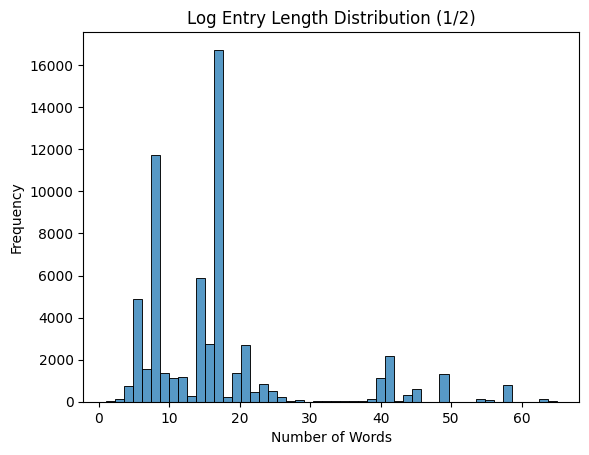

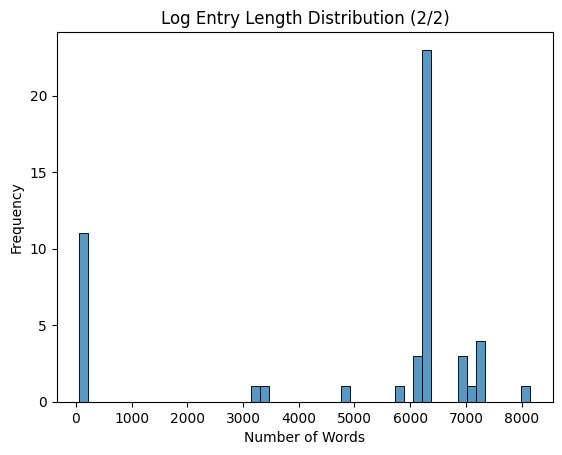

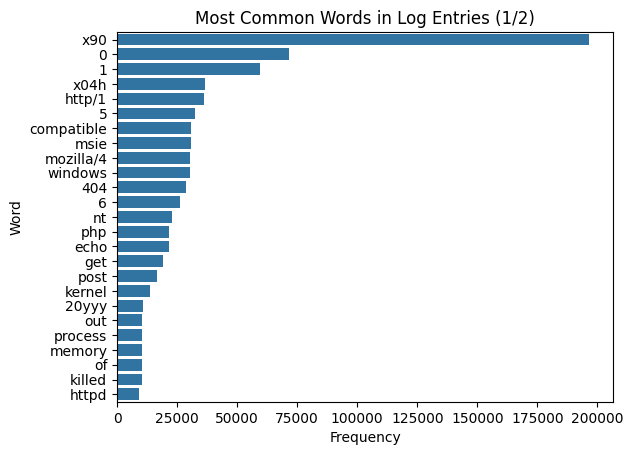

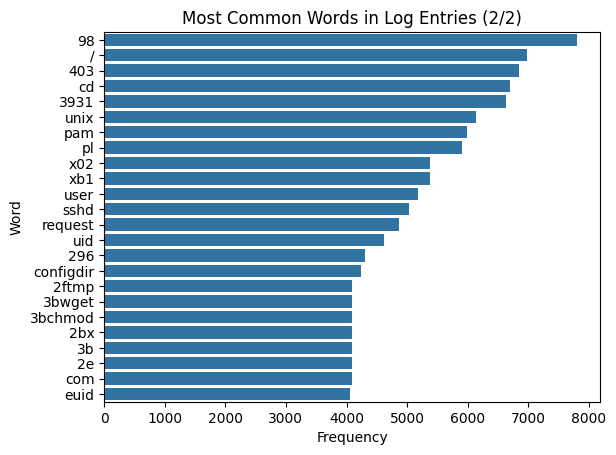

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# load from the combined dataset.csv
tgt_file = DATA_DIR+'/dataset.csv'
df_httpd = pd.read_csv(tgt_file)

# Visualizing the distribution of log entries' lengths
# df_content = df['content']

def eda_word_count(p_df: pandas.Series=None) -> None:
    # print(p_df.apply(lambda x: len(str(x).split())))
    df_content = p_df
    df['log_length'] = df_content.apply(lambda x: len(str(x).split()))
    
#     display(sorted(df['log_length'],reverse=True))
    
    df_descending = sorted(df['log_length'],reverse=True)
    
#     sns.histplot(df['log_length'], bins=1000)
    sns.histplot(df_descending[50:], bins=50)
    plt.title('Log Entry Length Distribution (1/2)')
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')
    plt.show()

    sns.histplot(df_descending[:50], bins=50)
    plt.title('Log Entry Length Distribution (2/2)')
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')

    plt.show()

def eda_word_freq(p_df: pandas.Series=None)->None:
    df_content = p_df
    # Extracting and visualizing most common log entries (terms)
    from collections import Counter
    all_words = ' '.join(df_content).split()
    # print(f"all_words >>> {all_words}")
    common_words = Counter(all_words).most_common(50)

    # Bar plot for most common words
    common_words_df = pd.DataFrame(common_words[:25], columns=['Word', 'Frequency'])
    sns.barplot(x='Frequency', y='Word', data=common_words_df)
    plt.title('Most Common Words in Log Entries (1/2)')
    plt.show()

#     return
    common_words_df = pd.DataFrame(common_words[26:], columns=['Word', 'Frequency'])
    sns.barplot(x='Frequency', y='Word', data=common_words_df)
    plt.title('Most Common Words in Log Entries (2/2)')
    plt.show()

eda_word_count(df['content'].copy())
# display(df.loc[14740:14750])
eda_word_freq(df['content'].copy())

# Feature Extraction

In [20]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [19]:
# feature extraction

# def feature_extraction(p_df: pandas.DataFrame=None, p_col_content: str='content', p_col_label: str='log_type'):
p_df = df
p_col_content = 'content'
p_col_label = 'log_type'

tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(p_df[p_col_content]).toarray()

# column label for log data
y = LabelEncoder().fit_transform(df[p_col_label])

In [20]:
save_obj(p_obj=tfidf, p_filename=TFIDF_FILE)

# Model Training, Testing & Validation

**Key hyperparameters** that can be further tuned or included to improve model performance:
- `clf__n_estimators` (number of trees in the forest)
- `clf__max_depth` (maximum depth of the individual trees; limits the number of nodes in the tree)
- `clf__min_samples_leaf` (minimum samples required to be at a leaf node)
- `max_features` (number of features to consider at each split)



In a Random Forest, each decision tree is trained on a random subset of the features. The `max_features` parameter controls how many features are considered when splitting a node in each tree. This randomness helps to ensure that the trees are not too similar to each other, which is a key aspect of the ensemble method.

In [21]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [22]:
# Pipeline with RandomForestClassifier
pipeline = Pipeline([
    ('clf', RandomForestClassifier())
])

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [10, 20, None],
    'clf__min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=4)
grid_search.fit(X_train, y_train)

# Best parameters and model
print(f"Best Parameters: {grid_search.best_params_}")
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


# Save Model

In [ ]:
save_obj(p_obj=best_model, p_filename=MODEL_FILE)

# Load & Evaluate Model

In [ ]:
tgt_tfidf = load_obj(p_filename=TFIDF_FILE)
tgt_model = load_obj(p_filename=MODEL_FILE)

In [ ]:
print(X_test)

In [ ]:
# Predicting on test set
y_pred = tgt_model.predict(X_test)

# Evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# Deploy Model for Inference

In [ ]:
# tgt_model = load_obj(p_filename='/content/drive/MyDrive/sctp-capstone-ml-log-data/model/'+'log_classifier_model.sav')
# save_obj(p_obj=tfidf, p_filename='/content/drive/MyDrive/sctp-capstone-ml-log-data/model/'+'tfidf_vectorizer.sav')

model = None
tfidf_vectorizer = None

# Load the trained model from the pickle file
# filename='/content/drive/MyDrive/sctp-capstone-ml-log-data/model/'+'log_classifier_model.sav'
filename = MODEL_FILE
with open(filename, 'rb') as model_file:
    model = pickle.load(model_file)

# Load the TF-IDF vectorizer
# filename='/content/drive/MyDrive/sctp-capstone-ml-log-data/model/'+'tfidf_vectorizer.sav'
filename = TFIDF_FILE
with open(filename, 'rb') as vectorizer_file:
    tfidf_vectorizer = pickle.load(vectorizer_file)

print(tfidf_vectorizer)
print(model)

In [ ]:

def classify_log(input_text: list = None):
    tmp = input_text.split('\n')
    print(f"{type(input_text)}\n{tmp}")

    # Preprocess and vectorize the input text
    # input_text_cleaned = clean_str(input_text)
    input_text_cleaned = [ clean_str(i) for i in input_text.split('\n') if len(i)>0 ]
    print(input_text_cleaned)

    # input_vector = tfidf_vectorizer.transform([input_text_cleaned]).toarray()
    input_vector = tfidf_vectorizer.transform(input_text_cleaned).toarray()

    # Predict the log type
    prediction = model.predict(input_vector)

    # Return the prediction as a readable label
    return f"Predicted Log Type: {prediction[0]}"

# def classify_log_file(log_file):
#     # Read the text file and concatenate the lines into a single string
#     log_text = log_file.read().decode('utf-8')
#     return classify_log(log_text)

# Define the Gradio interface
iface = gr.Interface(
    fn=classify_log,  # Function to classify text input
    # inputs = gr.interface .inputs.Textbox(lines=10, placeholder="Enter log text here..."),  # Text input
    inputs = gr.Textbox(lines=3, placeholder="Enter log text (line by line) here..."),  # Text input
    outputs="text",  # Text output
    title="Log File Classifier",
    description="Submit 1 log entry per line to classify the type of log."
)

# iface_file_upload = gr.Interface(
#     fn=classify_log_file,  # Function to classify uploaded text file
#     # inputs=gr.inputs.File(type="file"),  # File input
#     inputs = gr.File(type="filepath"),  # File input
#     outputs="text",  # Text output
#     title="Log File Classifier (File Upload)",
#     description="Upload a log file to classify the type of log."
# )

# Combine both interfaces
# iface = gr.TabbedInterface([iface, iface_file_upload], ["Text Input", "File Upload"])
iface = gr.TabbedInterface([iface], ["Text Input"])



In [1]:
# toggle to deploy
# do not deploy if running to collect artifacts

DEPLOY = False 

if DEPLOY:
    # Launch the interface
    iface.launch(debug=True,share=True)
